In [10]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from collections import Counter
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

# 1. Load Environment (API Key needed for the Grader LLM)
load_dotenv()

# 2. Configuration
RESULTS_FILE = "data/results/debate_results.json"
CHARTS_DIR = "data/results"
os.makedirs(CHARTS_DIR, exist_ok=True)

# 3. Set Visual Style
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 12})

print("Environment Ready.")

Environment Ready.


In [11]:
# --- CELL 2: LOAD DATA & DEFINE HELPER FUNCTIONS (STRICT & SAFE) ---

if not os.path.exists(RESULTS_FILE):
    raise FileNotFoundError(f"❌ Results file not found at {RESULTS_FILE}. Run 1_run_debate.py first.")

with open(RESULTS_FILE, "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data)
print(f"Loaded {len(df)} debate records.")

# 1. Voting Logic Helper
def get_voting_answer(row):
    try:
        solvers = row['full_state']['solvers_data']
        answers = [str(s.get('raw_response', {}).get('final_answer_short', 'Error')).strip().lower() for s in solvers]
        counts = Counter(answers)
        if not counts: return "No Data"
        most_common = counts.most_common(1)[0]
        if most_common[1] >= 2: return most_common[0]
        return answers[0] 
    except: return "Error"

# 2. Strict LLM Judge (The Grader) - SAFE AGAINST MATH BRACKETS
grader_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

def check_correctness(target_answer, model_answer):
    if not model_answer or str(model_answer) in ["No Answer", "Error", "No Answer Provided"]: 
        return False
    
    t_clean = str(target_answer).lower().strip()
    m_clean = str(model_answer).lower().strip()
    
    # Fast path: String match
    if t_clean in m_clean: return True
    
    # Slow path: LLM Judge (NO f-strings in the template!)
    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a strict Exam Grader. Compare Student Answer to Target Key.
        RULES: 
        1. Units (8km vs 8000m) and rounding (7997 vs 8000) = PASS.
        2. Integers (503 vs 504) = FAIL.
        Reply ONLY with 'PASS' or 'FAIL'."""),
        ("human", "TARGET: {target}\nSTUDENT: {student}\n\nGRADE:")
    ])
    
    try:
        chain = prompt | grader_llm
        # We pass variables safely here
        res = chain.invoke({
            "target": str(target_answer), 
            "student": str(model_answer)
        })
        return "PASS" in res.content.upper() and "FAIL" not in res.content.upper()
    except Exception as e:
        return False

# 3. Consensus Checker
def check_consensus(row):
    try:
        solvers = row['full_state']['solvers_data']
        a1 = str(solvers[0]['raw_response']['final_answer_short']).strip().lower()
        a2 = str(solvers[1]['raw_response']['final_answer_short']).strip().lower()
        a3 = str(solvers[2]['raw_response']['final_answer_short']).strip().lower()
        return (a1 == a2) and (a2 == a3)
    except: return False

# 4. Improvement Checker
def check_improvement(row):
    try:
        target = row['correct_answer']
        s1_initial = row['full_state']['solvers_data'][0]['raw_response']['final_answer_short']
        agent_name = row['full_state']['solvers_data'][0]['agent']
        refined_list = row['full_state']['refined_data']
        s1_final = next((r['final_answer'] for r in refined_list if r['agent'] == agent_name), "Error")
        
        initial_ok = check_correctness(target, s1_initial)
        final_ok = check_correctness(target, s1_final)
        return (not initial_ok) and final_ok
    except: return False

print("Helper functions defined.")

Loaded 25 debate records.
Helper functions defined.


In [12]:
print("Performing Deep Analysis of Agent Dynamics... (This takes a few minutes)")

# 1. Calculate Voting Baseline Answer
df['voting_answer'] = df.apply(get_voting_answer, axis=1)

# 2. Grade the main results
df['debate_correct'] = df.apply(lambda row: check_correctness(row['correct_answer'], row['debate_answer']), axis=1)
df['baseline_correct'] = df.apply(lambda row: check_correctness(row['correct_answer'], row['baseline_answer']), axis=1)
df['voting_correct'] = df.apply(lambda row: check_correctness(row['correct_answer'], row['voting_answer']), axis=1)

# 3. INTERNAL DYNAMICS GRADING
def analyze_internal_correctness(row):
    target = row['correct_answer']
    
    # Grade Initial Solvers (Stage 1)
    initial_solvers = row['full_state']['solvers_data']
    initial_grades = [check_correctness(target, s['raw_response']['final_answer_short']) for s in initial_solvers]
    
    # Grade Refined Solvers (Stage 3)
    # We match them by agent name to see if THEY changed their mind
    refined_solvers = row['full_state']['refined_data']
    refined_grades = []
    for s_init in initial_solvers:
        name = s_init['agent']
        # Find the matching refined version
        refined_match = next((r for r in refined_solvers if r['agent'] == name), None)
        if refined_match:
            refined_grades.append(check_correctness(target, refined_match['final_answer']))
        else:
            refined_grades.append(False)
            
    return pd.Series({
        'any_solver_initially_right': any(initial_grades),
        'all_solvers_initially_right': all(initial_grades),
        'num_correct_initial': sum(initial_grades),
        'num_correct_refined': sum(refined_grades),
        # Degradation: At least one solver was Right then became Wrong
        'had_degradation': any([i and not r for i, r in zip(initial_grades, refined_grades)]),
        # Recovery: At least one solver was Wrong then became Right
        'had_recovery': any([not i and r for i, r in zip(initial_grades, refined_grades)])
    })

# Apply the deep analysis
deep_metrics = df.apply(analyze_internal_correctness, axis=1)
df = pd.concat([df, deep_metrics], axis=1)

# 4. Final Calculations
df['consensus'] = df.apply(check_consensus, axis=1)
# Judge "Missed" Truth = Truth was in the room (any_solver_initially_right) but Judge was wrong
df['judge_missed_truth'] = df['any_solver_initially_right'] & ~df['debate_correct']

print("Deep Analysis Complete.")

Performing Deep Analysis of Agent Dynamics... (This takes a few minutes)
Deep Analysis Complete.


In [13]:
print("Starting Final Evaluation (calculating all metrics)...")

# 1. First, calculate the basic answer columns
df['voting_answer'] = df.apply(get_voting_answer, axis=1)

# 2. Grade the outputs (This makes the API calls)
print("   - Grading Debate results...")
df['debate_correct'] = df.apply(lambda row: check_correctness(row['correct_answer'], row['debate_answer']), axis=1)

print("   - Grading Baseline results...")
df['baseline_correct'] = df.apply(lambda row: check_correctness(row['correct_answer'], row['baseline_answer']), axis=1)

print("   - Grading Voting results...")
df['voting_correct'] = df.apply(lambda row: check_correctness(row['correct_answer'], row['voting_answer']), axis=1)

# 3. Calculate internal metrics
print("   - Calculating Consensus and Improvement...")
df['consensus'] = df.apply(check_consensus, axis=1)
df['improved'] = df.apply(check_improvement, axis=1)

# 4. Calculate Judge Accuracy on Disagreement
# We filter only rows where the solvers disagreed
disagreement_df = df[df['consensus'] == False]
if len(disagreement_df) > 0:
    judge_acc_disagreement = disagreement_df['debate_correct'].mean()
else:
    judge_acc_disagreement = 0.0

print("\n" + "="*40)
print("FINAL METRICS REPORT")
print("="*40)
print(f"1. Debate System Accuracy:   {df['debate_correct'].mean():.1%}")
print(f"2. Single LLM Baseline:      {df['baseline_correct'].mean():.1%}")
print(f"3. Voting Baseline:          {df['voting_correct'].mean():.1%}")
print("-" * 40)
print(f"4. Consensus Rate:           {df['consensus'].mean():.1%}")
print(f"5. Improvement Rate:         {df['improved'].mean():.1%}")
print(f"6. Judge Acc. (Disagreement):{judge_acc_disagreement:.1%}")
print("="*40)

# --- TRUTH DETECTOR TABLE ---
print(f"\n{'ID':<4} | {'Correct':<10} | {'Debate':<10} | {'Grade':<6} | {'Consensus?'}")
print("-" * 55)

for index, row in df.iterrows():
    grade = "✅" if row['debate_correct'] else "❌"
    cons = "Yes" if row['consensus'] else "No"
    c_short = str(row['correct_answer'])[:10]
    d_short = str(row['debate_answer'])[:10]
    print(f"{row['id']:<4} | {c_short:<10} | {d_short:<10} | {grade:<6} | {cons}")

Starting Final Evaluation (calculating all metrics)...
   - Grading Debate results...
   - Grading Baseline results...
   - Grading Voting results...
   - Calculating Consensus and Improvement...

FINAL METRICS REPORT
1. Debate System Accuracy:   36.0%
2. Single LLM Baseline:      48.0%
3. Voting Baseline:          36.0%
----------------------------------------
4. Consensus Rate:           28.0%
5. Improvement Rate:         12.0%
6. Judge Acc. (Disagreement):22.2%

ID   | Correct    | Debate     | Grade  | Consensus?
-------------------------------------------------------
1    | 503        | 503        | ✅      | Yes
2    | tan(θ) >=  | θ ≥ tan^(- | ❌      | No
3    | 371        | 61         | ❌      | No
4    | 8h * sin(α | D = \frac{ | ❌      | No
5    | Approximat | The differ | ✅      | No
6    | (q^2 / (8  | W = \frac{ | ❌      | No
7    | 5.0        | 5          | ✅      | No
8    | Impossible | The inhabi | ❌      | Yes
9    | A is a Kni | A is the K | ✅      | No
10   | The def

C:\Users\comp\AppData\Local\Temp\ipykernel_15580\2734067139.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=accuracy_data, x='Method', y='Accuracy', palette='viridis')


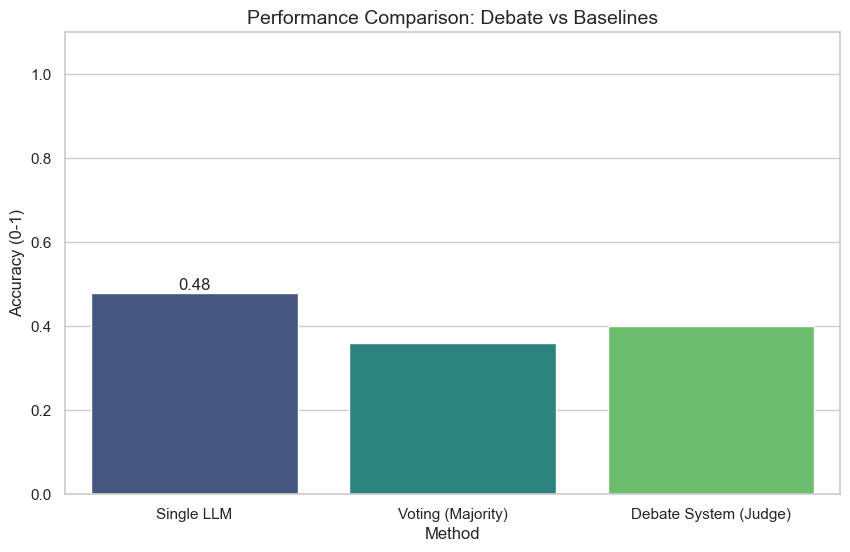

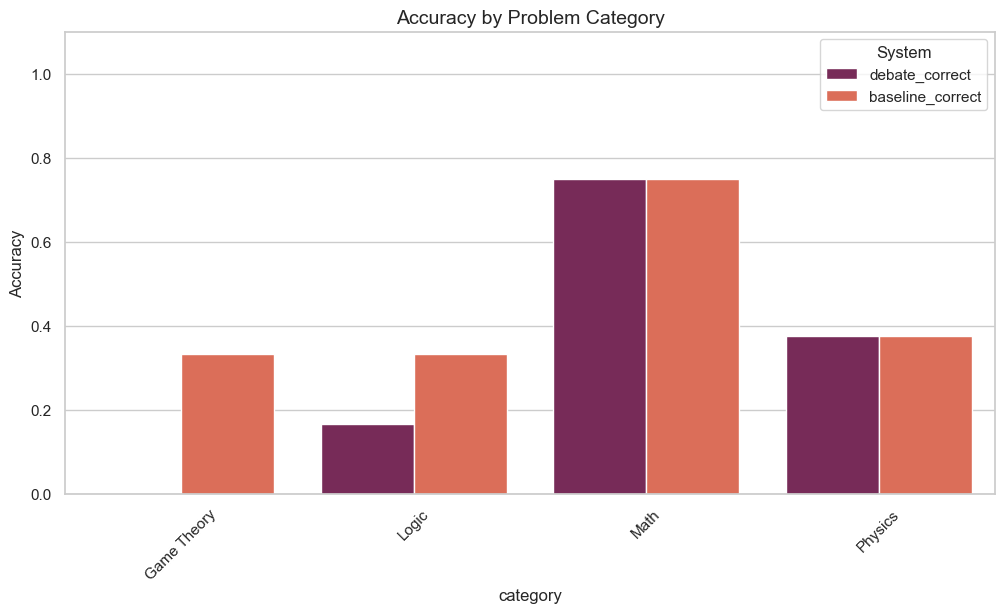

In [15]:
# Chart 1: Accuracy Comparison Bar Chart
plt.figure(figsize=(10, 6))
accuracy_data = pd.DataFrame({
    'Method': ['Single LLM', 'Voting (Majority)', 'Debate System (Judge)'],
    'Accuracy': [df['baseline_correct'].mean(), df['voting_correct'].mean(), df['debate_correct'].mean()]
})
ax = sns.barplot(data=accuracy_data, x='Method', y='Accuracy', palette='viridis')
ax.bar_label(ax.containers[0], fmt='%.2f')
plt.title('Performance Comparison: Debate vs Baselines', fontsize=14)
plt.ylabel('Accuracy (0-1)')
plt.ylim(0, 1.1)
plt.savefig("data/results/chart_accuracy.png")
plt.show()

# Chart 2: Accuracy by Category
plt.figure(figsize=(12, 6))
# Group by category and calculate mean of debate_correct
cat_acc = df.groupby('category')[['debate_correct', 'baseline_correct']].mean().reset_index()
cat_melted = cat_acc.melt(id_vars='category', var_name='System', value_name='Accuracy')

sns.barplot(data=cat_melted, x='category', y='Accuracy', hue='System', palette='rocket')
plt.title('Accuracy by Problem Category', fontsize=14)
plt.ylim(0, 1.1)
plt.xticks(rotation=45)
plt.savefig("data/results/chart_category.png")
plt.show()

C:\Users\comp\AppData\Local\Temp\ipykernel_15580\2713523099.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=judge_perf_data, x='Metric', y='Value', palette="Blues_d")


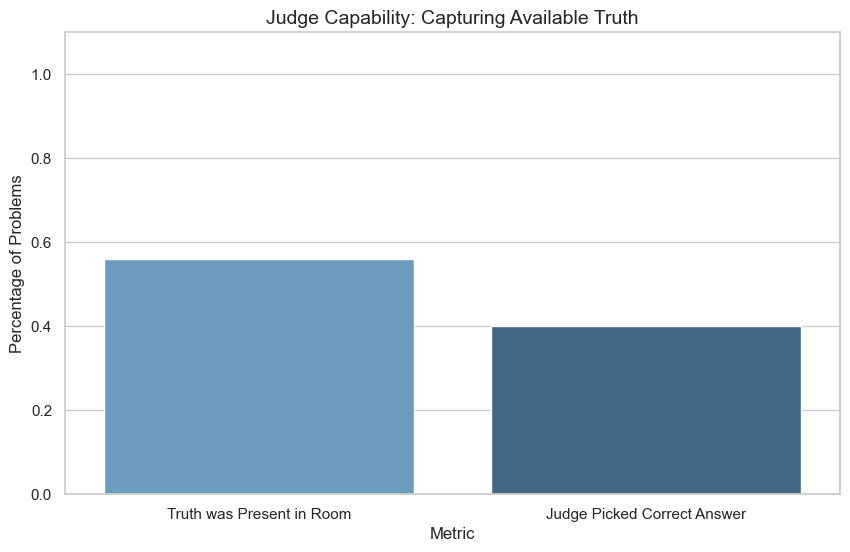

C:\Users\comp\AppData\Local\Temp\ipykernel_15580\2713523099.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=dynamics_data, x='Effect', y='Rate', palette="coolwarm")


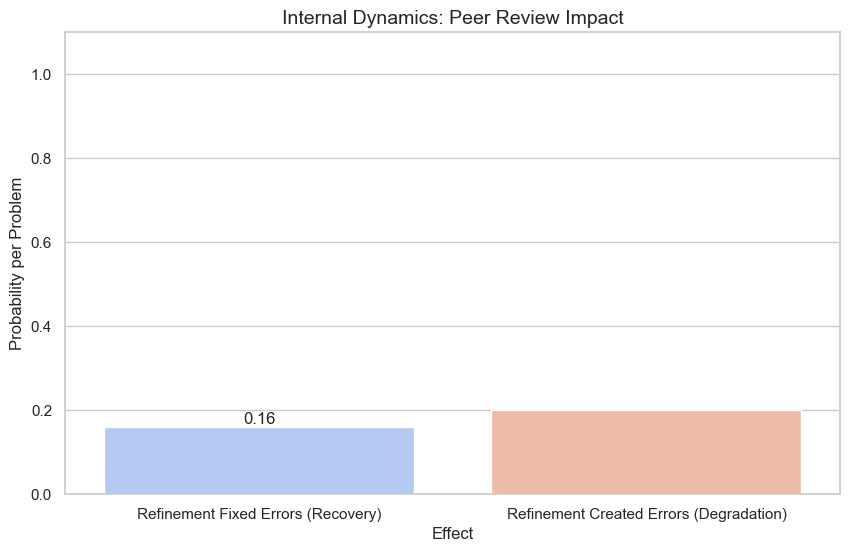

C:\Users\comp\AppData\Local\Temp\ipykernel_15580\2713523099.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='debate_correct', y='judge_confidence', palette="Set2")



DETAILED DYNAMICS REPORT
Judge Missed Truth Rate:   16.0%
Solution Degradation Rate: 20.0%
Solution Recovery Rate:    16.0%
Saved Chart 5 to data/results\chart_confidence_calibration.png


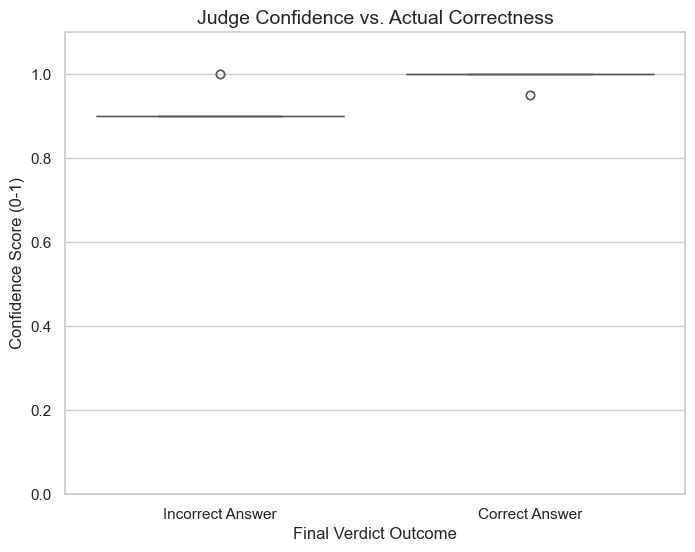

 Saved Chart 4 to data/results\chart_personality_bias.png


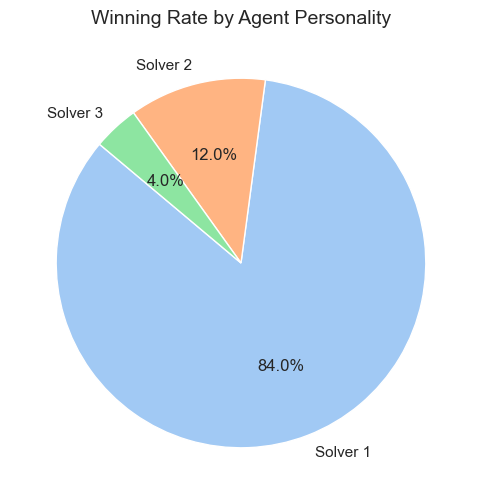

In [ ]:
# --- CHART 3: JUDGE EFFECTIVENESS ---
plt.figure(figsize=(10, 6))
judge_perf_data = pd.DataFrame({
    'Metric': ['Truth was Present in Room', 'Judge Picked Correct Answer'],
    'Value': [df['any_solver_initially_right'].mean(), df['debate_correct'].mean()]
})
sns.barplot(data=judge_perf_data, x='Metric', y='Value', palette="Blues_d")
plt.title('Judge Capability: Capturing Available Truth', fontsize=14)
plt.ylabel('Percentage of Problems')
plt.ylim(0, 1.1)
plt.savefig("data/results/chart_judge_effectiveness.png")
plt.show()

# --- CHART 4: TRANSFORMATION DYNAMICS (Right vs Wrong) ---
plt.figure(figsize=(10, 6))
# We want to compare how many problems had at least one "Save" (Wrong -> Right)
# vs at least one "Corruption" (Right -> Wrong)
dynamics_data = pd.DataFrame({
    'Effect': ['Refinement Fixed Errors (Recovery)', 'Refinement Created Errors (Degradation)'],
    'Rate': [df['had_recovery'].mean(), df['had_degradation'].mean()]
})
ax = sns.barplot(data=dynamics_data, x='Effect', y='Rate', palette="coolwarm")
ax.bar_label(ax.containers[0], fmt='%.2f')
plt.title('Internal Dynamics: Peer Review Impact', fontsize=14)
plt.ylabel('Probability per Problem')
plt.ylim(0, 1.1)
plt.savefig("data/results/chart_dynamics.png")
plt.show()

print("\nDETAILED DYNAMICS REPORT")
print("="*30)
print(f"Judge Missed Truth Rate:   {df['judge_missed_truth'].mean():.1%}")
print(f"Solution Degradation Rate: {df['had_degradation'].mean():.1%}")
print(f"Solution Recovery Rate:    {df['had_recovery'].mean():.1%}")

# --- CHART 5: CONFIDENCE CALIBRATION ---
plt.figure(figsize=(8, 6))

# Extract confidence from the final_verdict inside full_state
df['judge_confidence'] = df['full_state'].apply(lambda x: x['final_verdict'].get('confidence', 0))

# Create boxplot
sns.boxplot(data=df, x='debate_correct', y='judge_confidence', palette="Set2")

# Formatting
plt.xticks([0, 1], ['Incorrect Answer', 'Correct Answer'])
plt.title('Judge Confidence vs. Actual Correctness', fontsize=14)
plt.ylabel('Confidence Score (0-1)')
plt.xlabel('Final Verdict Outcome')
plt.ylim(0, 1.1)

# Save image
save_path_5 = os.path.join(CHARTS_DIR, "chart_confidence_calibration.png")
plt.savefig(save_path_5)
print(f"Saved Chart 5 to {save_path_5}")
plt.show()

# --- CHART 7: WIN RATE BY PERSONALITY ---
plt.figure(figsize=(10, 6))

# Extract the winner_id (which we fixed to be the Name earlier)
win_counts = df['full_state'].apply(lambda x: x['final_verdict'].get('winner_id', 'Unknown')).value_counts()

# Plot as a pie chart
win_counts.plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette("pastel"), startangle=140)

# Formatting
plt.title('Winning Rate by Agent Personality', fontsize=14)
plt.ylabel('') # Remove the default 'None' label

# Save image
save_path_6 = os.path.join(CHARTS_DIR, "chart_personality_bias.png")
plt.savefig(save_path_6)
print(f" Saved Chart 4 to {save_path_6}")
plt.show()




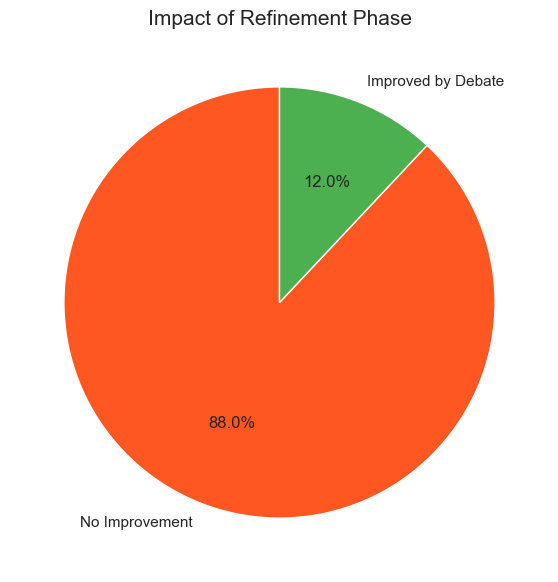

In [17]:
# --- CHART 8: IMPROVEMENT PIE ---
plt.figure(figsize=(7, 7))
improved_counts = df['improved'].value_counts()
# Ensure we have labels even if 0% improvement
labels = ['No Improvement', 'Improved by Debate'] if True in improved_counts.index else ['No Improvement']
plt.pie(df['improved'].value_counts(sort=False), labels=labels, autopct='%1.1f%%', colors=['#FF5722', '#4CAF50'], startangle=90)
plt.title('Impact of Refinement Phase', fontsize=15)
plt.savefig("data/results/chart_improvement_pie.png")
plt.show()